In [ ]:
# !pip3 install xgboost
# !pip3 install decision-tree-morfist
# !pip3 install catboost
# !pip3 install openpyxl

In [1]:
import config
import ast
import pickle
import pandas as pd
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import statistics

from utils.pandas_dataframe import grid_display
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from itertools import permutations
import gc

# validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor

# grid search
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.model_selection import GridSearchCV


from sklearn.multioutput import RegressorChain
from sklearn.multioutput import MultiOutputRegressor

from IPython.display import display


%matplotlib inline

C:\Users\Albert\anaconda3\envs\py38\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format',lambda x: '%.2f' % x)
# pd.set_option('display.max_rows', 5)
pd.set_option('display.max_rows', None)

In [3]:
def Col_types(Data):
    Column_types = Data.dtypes.to_frame().reset_index()
    Column_types.columns = ['ColumnName', 'Type']
    Column_types.sort_values( by= 'Type', inplace = True)
    return Column_types

def Missing_Counts(Data):
    missing = Data.isnull().sum()
    missing = missing[ missing >0]
    missing.sort_values( inplace=True)
    Missing_Count = pd.DataFrame({ 'ColumnName':missing.index, 'MissingCount':missing.values})
    Missing_Count['Percentage(%)'] = Missing_Count['MissingCount'].apply(lambda x:round(x/Data.shape[0]*100,2))
    return Missing_Count

In [4]:
with open('../Data/meta/train_x_after_feature_engineering.pickle', 'rb') as f:
    data_x = pickle.load(f)
data_x.head()

,clean_pressure31,clean_pressure41,clean_pressure72,clean_pressure81,clean_pressure91,clean_pressure92,clean_pressure102,oven_pa1,oven_pa2,oven_pb1,...,painting_g9_act_hvc_group,painting_g10_act_hvv_group,painting_g10_act_hvc_group,painting_g11_act_a_air_group,painting_g11_act_hvc_group,env_rpi05_temp_group,env_rpi07_pm10_group,env_rpi07_pm25_group,env_rpi14_pm1_group,env_rpi15_pm1_group
0,-0.85,2.37,2.96,1.95,-0.41,-3.38,0.83,1.87,1.37,4.01,...,0,3,2,1,1,1,2,0,2,3
4,-0.86,2.37,2.96,1.82,-0.55,-3.38,0.83,1.95,1.32,3.38,...,3,3,2,1,1,1,0,2,2,3
5,-0.86,2.37,2.96,1.82,-0.55,-3.38,0.83,1.95,1.32,3.38,...,3,3,2,1,1,1,0,2,2,3
6,-0.86,2.37,2.96,1.82,-0.55,-3.38,0.83,1.95,1.32,3.38,...,3,3,2,1,1,1,0,2,2,3
7,-0.86,2.37,2.96,1.82,-0.55,-3.38,0.83,1.95,1.32,3.38,...,3,3,2,1,1,1,0,2,2,3


In [5]:
with open('../Data/meta/train_y_after_feature_engineering.pickle', 'rb') as f:
    data_y = pickle.load(f)
data_y.head()

,sensor_point5_i_value,sensor_point6_i_value,sensor_point7_i_value,sensor_point8_i_value,sensor_point9_i_value,sensor_point10_i_value
0,-2.93,-1.36,-1.12,-1.68,-0.75,-2.82
4,-1.75,-0.55,-1.91,-1.25,-1.20,-1.62
5,-2.93,-0.77,-1.04,-1.12,-1.60,-1.68
6,-2.46,-0.77,-0.72,-1.68,-0.60,-2.64
7,-2.38,-1.21,-1.28,-2.03,-1.95,-2.22


### 檢查資料屬性

In [6]:
display(Col_types(data_x))

,ColumnName,Type
0,clean_pressure31,float64
29,painting_g7_act_hvv,float64
30,painting_g9_act_hvv,float64
32,painting_g11_act_hvv,float64
33,painting_g12_act_a_air,float64
34,env_rpi05_hum,float64
35,env_rpi05_pm1,float64
36,env_rpi07_hum,float64
37,env_rpi07_pm10,float64
38,env_rpi07_temp,float64


### Onehot encoding轉換類別型變數，並將原類別型變數刪除

In [7]:
# onehot encoding
for index , col in enumerate(data_x.columns.tolist()):
    if data_x[col].dtype == 'object':
        data_x = data_x.join(pd.get_dummies(data_x[col],prefix=col))
        data_x = data_x.drop(col, axis = 1)

### 執行完onehot encoding後再次檢查資料屬性

In [ ]:
display(Col_types(data_x))

In [ ]:
display(data_x.columns.tolist())

# 1.X變數標準化

In [10]:
# X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y, train_size = 0.8, random_state = 3)

# X變數標準化
scaler = StandardScaler().fit(data_x)
data_x_S = scaler.transform(data_x)

# 2.迴圈計算每個Y在每個模型下的最佳超參數，並計算RMSE值及預測結果
### 分別計算每個Model的最佳超參數及RMSE，以判斷6個 Y的最佳 Model

In [ ]:
# 分別計算每個Model的最佳超參數及RMSE，以判斷6個 Y的最佳 Model
# model(含超參數設定)
Lasso_params_list = []
Ridge_params_list = []
XGB_params_list = []
KN_params_list = []
Ada_params_list = []
Cat_params_list = []

# K-fold RMSE
Lasso_RMSE = []
Ridge_RMSE = []
XGB_RMSE = []
KN_RMSE = []
Ada_RMSE = []
Cat_RMSE = []

Model_result = pd.DataFrame({})

for i in range(6):

# Gridsearch超參數範圍
  

# 1. Lasso_model
    # 交叉驗證取超參數    
    config.grid_search_Lasso.fit(data_x_S, data_y.iloc[:,i])

    # 建立 pipeline
    poly_Lasso_reg = Pipeline([('poly', PolynomialFeatures(degree = 2)),
                               ('std_scaler', StandardScaler()),
                               ('lasso_reg', Lasso(**config.grid_search_Lasso.best_params_))
                              ])
    
    # k-folde計算RMSE(cv = 5)
    Lasso_RMSE.append(-cross_val_score(poly_Lasso_reg, 
                                       data_x, data_y.iloc[:,i], 
                                       cv = 5, 
                                       scoring = 'neg_root_mean_squared_error').mean())

    # 訓練模型
    poly_Lasso_reg.fit(data_x, data_y.iloc[:,i])
    

# 2. Ridge_model
    # 交叉驗證取超參數
    config.grid_search_Ridge.fit(data_x_S, data_y.iloc[:,i])
    
    # 建立 pipeline
    poly_Ridge_reg = Pipeline([('poly', PolynomialFeatures(degree = 2)),
                               ('std_scaler', StandardScaler()),
                               ('lasso_reg', Ridge(**config.grid_search_Ridge.best_params_))
                              ])
    
    # k-folde計算RMSE(cv = 5)
    Ridge_RMSE.append(-cross_val_score(poly_Ridge_reg, 
                                       data_x, data_y.iloc[:,i], 
                                       cv = 5, 
                                       scoring = 'neg_root_mean_squared_error').mean())

    # 訓練模型
    poly_Ridge_reg.fit(data_x, data_y.iloc[:,i])

# 3. XGB_model
    # 交叉驗證取超參數  
    config.grid_search_XGB.fit(data_x_S, data_y.iloc[:,i])

    # 建立 pipeline    
    poly_XGB_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                            ('std_scaler', StandardScaler()),
                            ('xgb_reg', xgb.XGBRegressor(**config.grid_search_XGB.best_params_))
                            ])
    
    # k-folde計算RMSE(cv = 5)
    XGB_RMSE.append(-cross_val_score(poly_XGB_reg, 
                                    data_x, data_y.iloc[:,i], 
                                    cv = 5, 
                                    scoring = 'neg_root_mean_squared_error').mean())
    
    # 訓練模型    
    poly_XGB_reg.fit(data_x, data_y.iloc[:,i])


# 4. KN_model
    # 交叉驗證取超參數  
    config.grid_search_KN.fit(data_x_S, data_y.iloc[:,i])

    # 建立 pipeline
    poly_KN_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('KNR', KNeighborsRegressor(**config.grid_search_KN.best_params_))
                        ])
    
    # k-folde計算RMSE(cv = 5)
    KN_RMSE.append(-cross_val_score(poly_KN_reg, 
                                    data_x, data_y.iloc[:,i], 
                                    cv = 5, 
                                    scoring = 'neg_root_mean_squared_error').mean())
    
    # 訓練模型    
    poly_KN_reg.fit(data_x, data_y.iloc[:,i])    

# 5. Ada_model
    # 交叉驗證取超參數  
    config.grid_search_Ada.fit(data_x_S, data_y.iloc[:,i])

    # 建立 pipeline
    poly_Ada_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                             ('std_scaler', StandardScaler()),
                             ('Ada', AdaBoostRegressor(**config.grid_search_Ada.best_params_))
                            ]) 
    
    # k-folde計算RMSE(cv = 5)
    Ada_RMSE.append(-cross_val_score(poly_Ada_reg, 
                                     data_x, data_y.iloc[:,i], 
                                     cv = 5, 
                                     scoring = 'neg_root_mean_squared_error').mean())
    
    # 訓練模型    
    poly_Ada_reg.fit(data_x, data_y.iloc[:,i])        

    
# 6. Cat_model
    # 交叉驗證取超參數  
    config.grid_search_Cat.fit(data_x_S, data_y.iloc[:,i])

    # 建立 pipeline
    poly_Cat_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                             ('std_scaler', StandardScaler()),
                             ('Cat', CatBoostRegressor(**config.grid_search_Cat.best_params_))
                            ]) 
    
    # k-folde計算RMSE(cv = 5)
    Cat_RMSE.append(-cross_val_score(poly_Cat_reg, 
                                     data_x, data_y.iloc[:,i], 
                                     cv = 5, 
                                     scoring = 'neg_root_mean_squared_error').mean())
    
    # 訓練模型
    poly_Cat_reg.fit(data_x, data_y.iloc[:,i])       

    
# 將超參數放入List中
    Lasso_params_list.append(config.grid_search_Lasso.best_params_)
    Ridge_params_list.append(config.grid_search_Ridge.best_params_)
    XGB_params_list.append(config.grid_search_XGB.best_params_)
    KN_params_list.append(config.grid_search_KN.best_params_)
    Ada_params_list.append(config.grid_search_Ada.best_params_)
    Cat_params_list.append(config.grid_search_Cat.best_params_)   
    
# 將模型預測結果放入Model_result
    
    Model_result['Actual_'+ data_y.columns.tolist()[i]] = data_y.iloc[:,i]
    Model_result['Lasso_'+ data_y.columns.tolist()[i]] = poly_Lasso_reg.predict(data_x)
    Model_result['Ridge_'+ data_y.columns.tolist()[i]] = poly_Ridge_reg.predict(data_x)
    Model_result['XGB_'+ data_y.columns.tolist()[i]] = poly_XGB_reg.predict(data_x)
    Model_result['KN_'+ data_y.columns.tolist()[i]] = poly_KN_reg.predict(data_x)
    Model_result['Ada_'+ data_y.columns.tolist()[i]] = poly_Ada_reg.predict(data_x)    
    Model_result['Cat_'+ data_y.columns.tolist()[i]] = poly_Cat_reg.predict(data_x)  
    
# list 串接成 pandas表格    
Model_RMSE = pd.DataFrame({'Lasso':Lasso_params_list,
                           'Lasso_RMSE':Lasso_RMSE,
                           'Ridge':Ridge_params_list,
                           'Ridge_RMSE':Ridge_RMSE,
                           'XGB':XGB_params_list,
                           'XGB_RMSE':XGB_RMSE,
                           'KN':KN_params_list,
                           'KN_RMSE':KN_RMSE,
                           'Ada':Ada_params_list,
                           'Ada_RMSE':Ada_RMSE,
                           'Cat':Cat_params_list,
                           'Cat_RMSE':Cat_RMSE
                          }, index = list(data_y.columns))

display(Model_RMSE)
display(Model_result)

# 資料存成 Pickle檔案
with open('../Output/Model_RMSE.pickle', 'wb') as f:
    pickle.dump(Model_RMSE, f)
    
# with open('../Data/output/Model_result.pickle', 'wb') as f:
#     pickle.dump(Model_result, f)    
# 資料輸出到Excel檔案
# output = pd.ExcelWriter('../Data/output.xlsx')
# Model_RMSE.to_excel(output, sheet_name = 'Model_RMSE',index = False)
# Model_result.to_excel(output, sheet_name = 'Model_result',index = False)

# output.save()

In [12]:
# 讀取結果檔案

with open('../Output/Model_RMSE.pickle', 'rb') as f:
    Model_RMSE = pickle.load(f)

display(Model_RMSE)

# Model_RMSE = pd.read_excel('../Data/output.xlsx','Model_RMSE')
# Model_result = pd.read_excel('../Data/output.xlsx','Model_result')
# Model_RMSE.index = [data_y.columns]
# Model_RMSE

,Lasso,Lasso_RMSE,Ridge,Ridge_RMSE,XGB,XGB_RMSE,KN,KN_RMSE,Ada,Ada_RMSE,Cat,Cat_RMSE
sensor_point5_i_value,{'alpha': 0.1},1.04,{'alpha': 500},1.08,"{'learning_rate': 0.2, 'max_depth': 3, 'min_ch...",1.11,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",1.04,"{'learning_rate': 0.2, 'n_estimators': 100, 'r...",1.11,"{'depth': 8, 'eval_metric': 'RMSE', 'iteration...",1.05
sensor_point6_i_value,{'alpha': 0.1},1.01,{'alpha': 100},1.14,"{'learning_rate': 0.2, 'max_depth': 5, 'min_ch...",1.02,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",0.97,"{'learning_rate': 0.2, 'n_estimators': 100, 'r...",1.00,"{'depth': 2, 'eval_metric': 'RMSE', 'iteration...",0.93
sensor_point7_i_value,{'alpha': 0.1},0.94,{'alpha': 500},1.05,"{'learning_rate': 0.2, 'max_depth': 3, 'min_ch...",1.09,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",0.96,"{'learning_rate': 0.5, 'n_estimators': 100, 'r...",1.09,"{'depth': 5, 'eval_metric': 'RMSE', 'iteration...",1.01
sensor_point8_i_value,{'alpha': 0.1},0.98,{'alpha': 500},1.16,"{'learning_rate': 0.2, 'max_depth': 3, 'min_ch...",1.02,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",0.91,"{'learning_rate': 0.5, 'n_estimators': 300, 'r...",0.96,"{'depth': 5, 'eval_metric': 'RMSE', 'iteration...",1.03
sensor_point9_i_value,{'alpha': 1},1.07,{'alpha': 500},1.14,"{'learning_rate': 0.2, 'max_depth': 5, 'min_ch...",1.17,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",1.04,"{'learning_rate': 0.2, 'n_estimators': 300, 'r...",1.03,"{'depth': 8, 'eval_metric': 'RMSE', 'iteration...",1.05
sensor_point10_i_value,{'alpha': 0.5},1.02,{'alpha': 500},1.16,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",1.06,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",1.06,"{'learning_rate': 0.2, 'n_estimators': 100, 'r...",1.00,"{'depth': 8, 'eval_metric': 'RMSE', 'iteration...",1.00


In [13]:
# 各Y變數依據k-fold計算的 RMSE挑選最佳的Model(RMSE最小)
for i in range(6):
    Y_var = Model_RMSE[list(map(lambda x: x + '_RMSE', config.model_name))].iloc[i,:]
    Y_var = Y_var[Y_var == Y_var.min()].index[0]
    print(data_y.columns[i] +'_best model:' + Y_var)

sensor_point5_i_value_best model:Lasso_RMSE
sensor_point6_i_value_best model:Cat_RMSE
sensor_point7_i_value_best model:Lasso_RMSE
sensor_point8_i_value_best model:KN_RMSE
sensor_point9_i_value_best model:Ada_RMSE
sensor_point10_i_value_best model:Cat_RMSE


In [14]:
model_select = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                         ('std_scaler', StandardScaler()),
                         ('mod', config.model_info['Lasso']['Model'])  # 修改model
                        ])

model_select.fit(data_x, data_y.loc[:,config.Y_variable])

y_predict = model_select.predict(data_x)
y_predict

array([-1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -1.26472008e-16, -1.26472008e-16, -1.26472008e-16,
       -1.26472008e-16, -

In [15]:
k_fold_RMSE = -cross_val_score(model_select, 
                               data_x,
                               data_y.loc[:,config.Y_variable], 
                               cv = 5, 
                               scoring = 'neg_root_mean_squared_error').mean()

print('RMSE:' + str(round(k_fold_RMSE,2)))

RMSE:1.09


In [16]:
# 將最佳params轉成 dict型態

model_name = config.model_name

for m in model_name:
    # select model
    model_dict = Model_RMSE.loc[:,m].to_dict()
    for i in range(6):
        # 修改 key(如果資料匯入時index沒有帶入，將Key值轉為Y 變數欄位名稱)
        model_dict[data_y.columns[i]] = model_dict.pop(Model_RMSE.index[i])
        
        # 修改 value，將字串轉換成資料類型
        model_dict[data_y.columns[i]] = model_dict[data_y.columns[i]]
    display('model:' + m, 'params:' + str(model_dict))

'model:Ridge'

"params:{'sensor_point5_i_value': {'alpha': 500}, 'sensor_point6_i_value': {'alpha': 100}, 'sensor_point7_i_value': {'alpha': 500}, 'sensor_point8_i_value': {'alpha': 500}, 'sensor_point9_i_value': {'alpha': 500}, 'sensor_point10_i_value': {'alpha': 500}}"

'model:Lasso'

"params:{'sensor_point5_i_value': {'alpha': 0.1}, 'sensor_point6_i_value': {'alpha': 0.1}, 'sensor_point7_i_value': {'alpha': 0.1}, 'sensor_point8_i_value': {'alpha': 0.1}, 'sensor_point9_i_value': {'alpha': 1}, 'sensor_point10_i_value': {'alpha': 0.5}}"

'model:XGB'

"params:{'sensor_point5_i_value': {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 30, 'random_state': 1}, 'sensor_point6_i_value': {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 30, 'random_state': 1}, 'sensor_point7_i_value': {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 500, 'random_state': 1}, 'sensor_point8_i_value': {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 30, 'random_state': 1}, 'sensor_point9_i_value': {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 500, 'random_state': 1}, 'sensor_point10_i_value': {'learning_rate': 0.2, 'max_depth': 20, 'min_child_weight': 10, 'n_estimators': 30, 'random_state': 1}}"

'model:KN'

"params:{'sensor_point5_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}, 'sensor_point6_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}, 'sensor_point7_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}, 'sensor_point8_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}, 'sensor_point9_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}, 'sensor_point10_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}}"

'model:Ada'

"params:{'sensor_point5_i_value': {'learning_rate': 0.2, 'n_estimators': 100, 'random_state': 1}, 'sensor_point6_i_value': {'learning_rate': 0.2, 'n_estimators': 100, 'random_state': 1}, 'sensor_point7_i_value': {'learning_rate': 0.5, 'n_estimators': 100, 'random_state': 1}, 'sensor_point8_i_value': {'learning_rate': 0.5, 'n_estimators': 300, 'random_state': 1}, 'sensor_point9_i_value': {'learning_rate': 0.2, 'n_estimators': 300, 'random_state': 1}, 'sensor_point10_i_value': {'learning_rate': 0.2, 'n_estimators': 100, 'random_state': 1}}"

'model:Cat'

"params:{'sensor_point5_i_value': {'depth': 8, 'eval_metric': 'RMSE', 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'random_state': 1}, 'sensor_point6_i_value': {'depth': 2, 'eval_metric': 'RMSE', 'iterations': 1000, 'l2_leaf_reg': 0.5, 'learning_rate': 0.03, 'random_state': 1}, 'sensor_point7_i_value': {'depth': 5, 'eval_metric': 'RMSE', 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'random_state': 1}, 'sensor_point8_i_value': {'depth': 5, 'eval_metric': 'RMSE', 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'random_state': 1}, 'sensor_point9_i_value': {'depth': 8, 'eval_metric': 'RMSE', 'iterations': 500, 'l2_leaf_reg': 0.5, 'learning_rate': 0.03, 'random_state': 1}, 'sensor_point10_i_value': {'depth': 8, 'eval_metric': 'RMSE', 'iterations': 500, 'l2_leaf_reg': 0.5, 'learning_rate': 0.03, 'random_state': 1}}"

# 3.迴圈計算不同排列順序下RMSE結果，最終得出最佳RMSE的順序

*參考RegressionChain(Regression只能放一個模型，而且不能調整超參數)，將先預測的Y值放入X，再預測下一個Y

In [ ]:
# 排列訓練模型，再計算全部Y變數的RMSE平均數。最佳排列結果取RMSE合計最小

check = 1000
order_list = []
predict_RMSE_list = []
predict_RMSE_avg = []

# 取得排列 0~6清單
for i in list(permutations(range(6),6)):
    Model_RMSE = []
    X_PT = data_x
    
    # 按照排列順序訓練模型，計算RMSE
    for k in range(6):
        model = config.model_list[list(i)[k]]
        model.fit(X_PT, data_y.iloc[:,list(i)[k]])
        
        # 儲存預測結果
        Model_RMSE.append((np.sqrt(mean_squared_error(data_y.iloc[:,[list(i)[k]]] ,model.predict(X_PT)))))
        
        # 把取得的預測值當作變數放進X
        X_PT[data_y.columns[order_list[k]]+'_predict'] = model.predict(X_PT)


    order_list.append(''.join(str(list(i))))
    
    # 平均6個Y變數計算的RMSE
    predict_RMSE_avg.append(statistics.mean(Model_RMSE))
    
    # 個別6個Y變數的RMSE
    predict_RMSE_list.append(str(Model_RMSE))
    
    if statistics.mean(Model_RMSE) < check:
        check = statistics.mean(Model_RMSE)
        order_list_fn = str(list(i))


Order_result = pd.DataFrame({ 'Group':order_list,
                              'predict_RMSE_avg':predict_RMSE_avg,
                              'predict_RMSE_list':predict_RMSE_list})

display('best model list:' + order_list_fn)
display(Order_result)

### 最佳預測順序為[5, 3, 2, 1, 4, 0]，透過最佳順序計算RMSE

In [50]:
# order_list 迴圈後得出的最佳順序；model_list 各變數引用的模型

def Regression_Chain_Y(order_list, model_list):
    RMSE = []
    R2 = []
    predict_y_train = pd.DataFrame({})
    for k in range(6):
        # 按照排列順序訓練模型
        globals()['model_Y' + str(order_list[k])]= model_list[order_list[k]]
        globals()['model_Y' + str(order_list[k])].fit(X_PT, data_y.iloc[:,order_list[k]])
             
        # 儲存預測結果
        predict_y_train[config.data_y_col[order_list[k]]] = globals()['model_Y' + str(order_list[k])].predict(X_PT)
        
        # 把取得的預測值當作變數放進X
        X_PT[config.data_y_col[order_list[k]]] = globals()['model_Y' + str(order_list[k])].predict(X_PT)
        
        # RMSE     
        RMSE.append(config.data_y_col[order_list[k]] + ':' + \
                    str(np.sqrt(mean_squared_error(data_y.iloc[:,[order_list[k]]] ,predict_y_train[config.data_y_col[order_list[k]]]))))
        
        # R2
        R2.append(config.data_y_col[order_list[k]] + ':' + \
                  str(r2_score(data_y.iloc[:,[order_list[k]]] ,predict_y_train[config.data_y_col[order_list[k]]])))
        
        
    return RMSE, R2, predict_y_train, model_Y0, model_Y1, model_Y2, model_Y3, model_Y4, model_Y5

In [51]:
# 設定 model順序(按Y變數順序排列)
X_PT = data_x.copy()

RMSE, R2, predict_y_train, model_Y0, model_Y1, model_Y2, model_Y3, model_Y4, model_Y5 = Regression_Chain_Y(config.order_list, config.model_list)

# 調整欄位順序
predict_y_train = predict_y_train[config.data_y_col]

# 儲存訓練集預測結果
with open('../Output/predict_y_train(Albert).pickle', 'wb') as f:
    pickle.dump(predict_y_train, f)

# 儲存Model
with open('../model/model_Y0(Albert).pickle', 'wb') as f:
    pickle.dump(model_Y0, f)
    
with open('../model/model_Y1(Albert).pickle', 'wb') as f:
    pickle.dump(model_Y1, f)
    
with open('../model/model_Y2(Albert).pickle', 'wb') as f:
    pickle.dump(model_Y2, f)
    
with open('../model/model_Y3(Albert).pickle', 'wb') as f:
    pickle.dump(model_Y3, f)
    
with open('../model/model_Y4(Albert).pickle', 'wb') as f:
    pickle.dump(model_Y4, f)
    
with open('../model/model_Y5(Albert).pickle', 'wb') as f:
    pickle.dump(model_Y5, f)
    
display(RMSE)
display(R2)

0:	learn: 0.9846727	total: 1.22s	remaining: 10m 7s
1:	learn: 0.9709869	total: 2.14s	remaining: 8m 52s
2:	learn: 0.9594167	total: 2.97s	remaining: 8m 12s
3:	learn: 0.9481618	total: 3.77s	remaining: 7m 46s
4:	learn: 0.9367712	total: 4.6s	remaining: 7m 35s
5:	learn: 0.9263431	total: 5.4s	remaining: 7m 24s
6:	learn: 0.9157048	total: 6.19s	remaining: 7m 16s
7:	learn: 0.9044192	total: 6.98s	remaining: 7m 9s
8:	learn: 0.8942213	total: 7.76s	remaining: 7m 3s
9:	learn: 0.8830153	total: 8.53s	remaining: 6m 58s
10:	learn: 0.8751456	total: 9.29s	remaining: 6m 52s
11:	learn: 0.8651178	total: 10.1s	remaining: 6m 49s
12:	learn: 0.8566546	total: 10.9s	remaining: 6m 46s
13:	learn: 0.8493237	total: 11.7s	remaining: 6m 45s
14:	learn: 0.8424205	total: 12.5s	remaining: 6m 43s
15:	learn: 0.8359023	total: 13.3s	remaining: 6m 42s
16:	learn: 0.8277756	total: 14.1s	remaining: 6m 41s
17:	learn: 0.8195087	total: 14.9s	remaining: 6m 39s
18:	learn: 0.8137864	total: 15.7s	remaining: 6m 38s
19:	learn: 0.8080517	total

['sensor_point10_i_value0.46148312372532047',
 'sensor_point8_i_value0.36572734156552544',
 'sensor_point7_i_value0.4034143786260803',
 'sensor_point6_i_value0.342329194738506',
 'sensor_point9_i_value0.5701192469375991',
 'sensor_point5_i_value0.41567370671840437']

['sensor_point10_i_value0.7870333265167205',
 'sensor_point8_i_value0.8662435116314134',
 'sensor_point7_i_value0.8372568391177335',
 'sensor_point6_i_value0.8828107224296861',
 'sensor_point9_i_value0.674964044271305',
 'sensor_point5_i_value0.8272153695429819']

# 4.計算實際值跟預測值差異

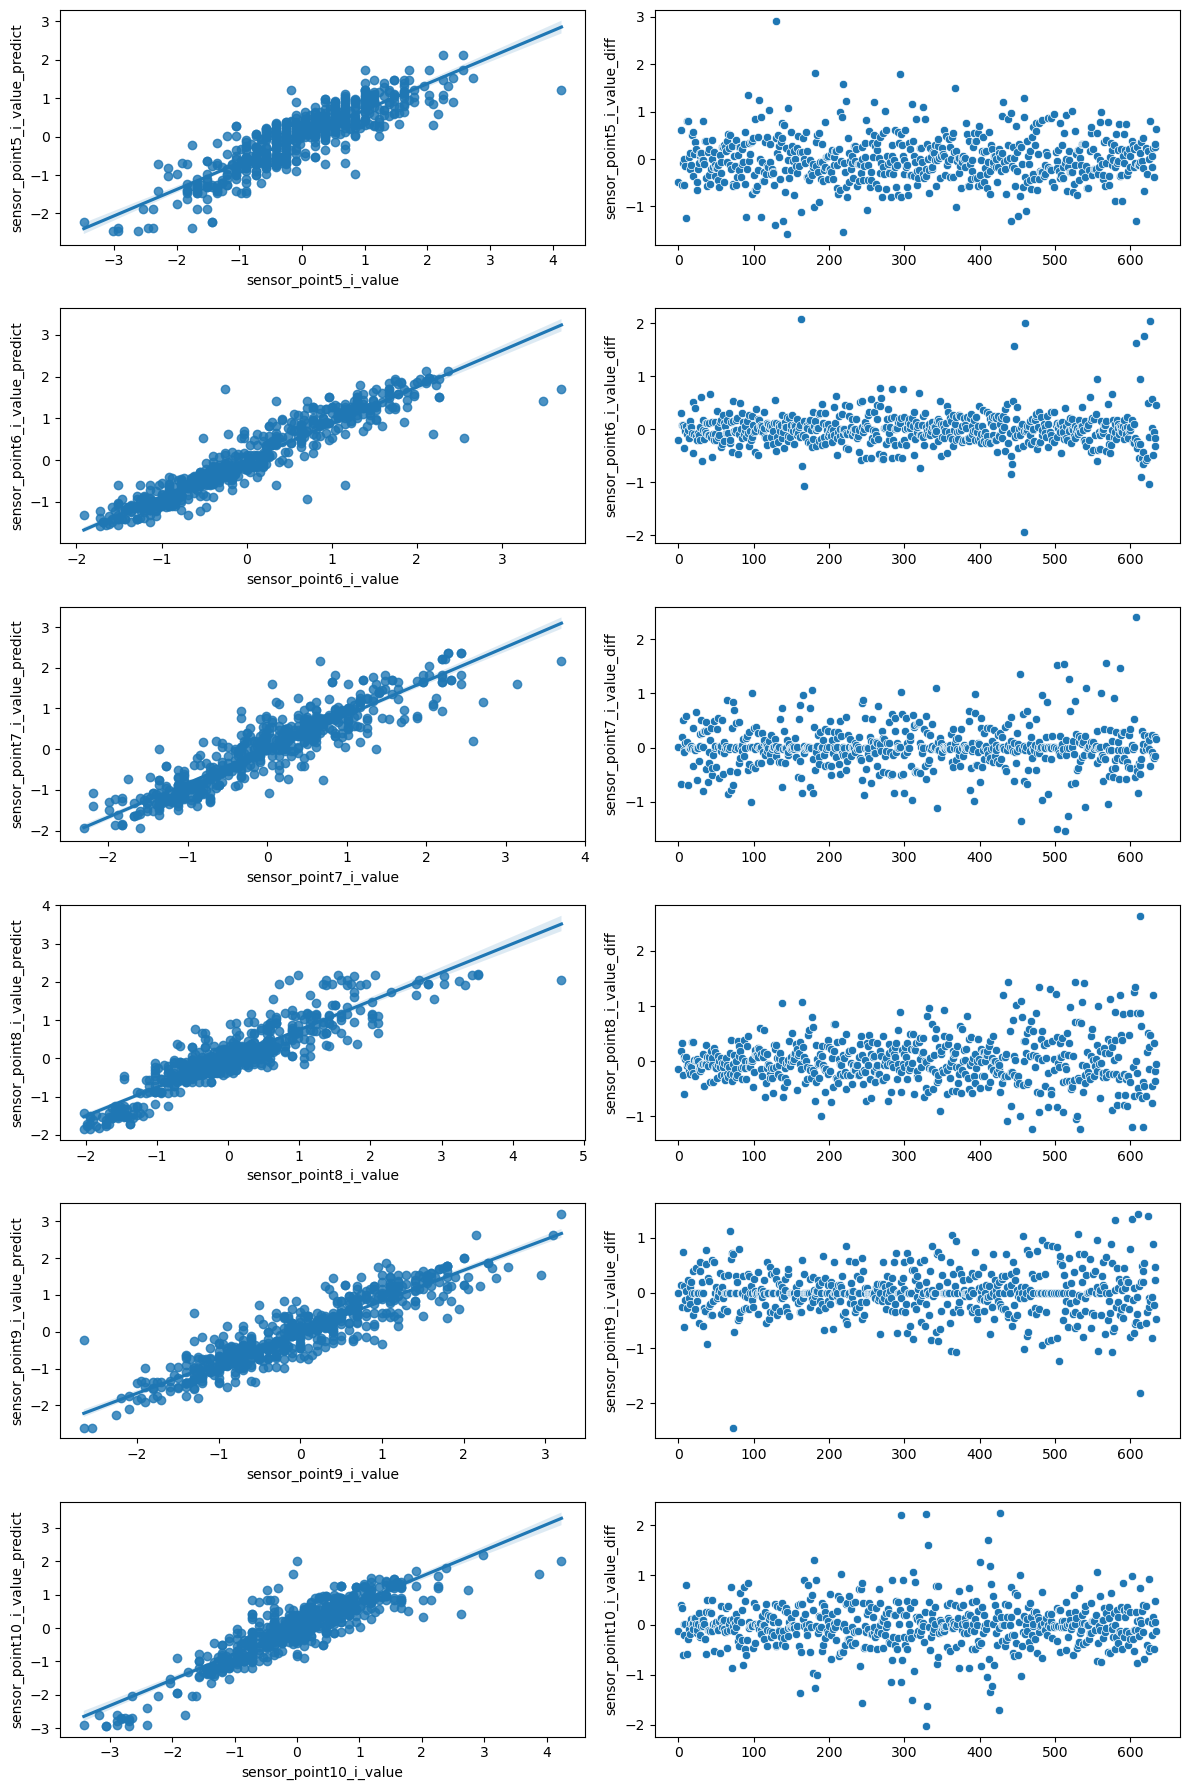

In [24]:
# 計算實際值跟預測值差異

data_T = Model_result # 資料類型
Model_ch = 'XGB' # 選擇 model

Y_predict_diff = data_y # 創建起始Table
for i in range(6):
    Y_predict_diff[data_y.columns.tolist()[i] + '_predict'] = data_T[Model_ch + '_' + data_y.columns.tolist()[i]]
    Y_predict_diff[data_y.columns.tolist()[i] + '_diff'] = data_T['Actual_' + data_y.columns.tolist()[i]]\
                                                            - data_T[Model_ch + '_' + data_y.columns.tolist()[i]]
# display(Y_predict_diff)

# seaborn呈現結果
fig, axes = plt.subplots(6, 2, figsize=(12, 18))

for i in range(6):
    # 預測值跟實際值分布狀況
    sns.regplot(x = data_y.columns.tolist()[i], 
                y = data_y.columns.tolist()[i] + '_predict', 
                data = Y_predict_diff, 
                ax=axes[i, 0])
    
    # 每筆資料的差異
    sns.scatterplot(x = Y_predict_diff.index,
                    y = data_y.columns.tolist()[i] + '_diff',
                    data = Y_predict_diff, 
                    ax=axes[i, 1])
    
    
plt.tight_layout()